# Vanguard S&P 500 ETF Forecast

&emsp;This project builds a **predictive model** for the *Vanguard S&P 500 ETF* stock price.

In [136]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.style.use('seaborn-v0_8-colorblind')
%matplotlib inline

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import r2_score

# Seed code
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

# Set environment variable for deterministic behavior
os.environ['PYTHONHASHSEED'] = str(1)

# Create Windowed Dataset Function

In [137]:
def create_dataset(orig_dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(orig_dataset) - window_size):
        window = orig_dataset.iloc[i:(i + window_size), 0]
        target = orig_dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

# Import Data

In [138]:
# Define the ticker symbol
ticker_symbol = "VOO"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
voo = ticker.history(period='max')  # data for the last year
print(f"Rows: {voo.shape[0]}\nColumns: {voo.shape[1]}")
voo.head()

Rows: 3627
Columns: 8


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2010-09-09 00:00:00-04:00,78.626508,78.626508,77.583268,77.721344,26500,0.0,0.0,0.0
2010-09-10 00:00:00-04:00,77.997503,78.135580,77.706012,78.074211,8600,0.0,0.0,0.0
2010-09-13 00:00:00-04:00,78.979376,79.117452,78.626516,79.056084,33750,0.0,0.0,0.0
2010-09-14 00:00:00-04:00,78.887320,79.378262,78.534460,79.040741,59400,0.0,0.0,0.0
2010-09-15 00:00:00-04:00,78.718531,79.301513,78.549770,79.240150,9250,0.0,0.0,0.0


In [139]:
voo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3627 entries, 2010-09-09 00:00:00-04:00 to 2025-02-07 00:00:00-05:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           3627 non-null   float64
 1   High           3627 non-null   float64
 2   Low            3627 non-null   float64
 3   Close          3627 non-null   float64
 4   Volume         3627 non-null   int64  
 5   Dividends      3627 non-null   float64
 6   Stock Splits   3627 non-null   float64
 7   Capital Gains  3627 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 255.0 KB


* Apparently, there are no missing values.
* For simplicity, `Close` will be used for the analysis and forecasting in the baseline models.

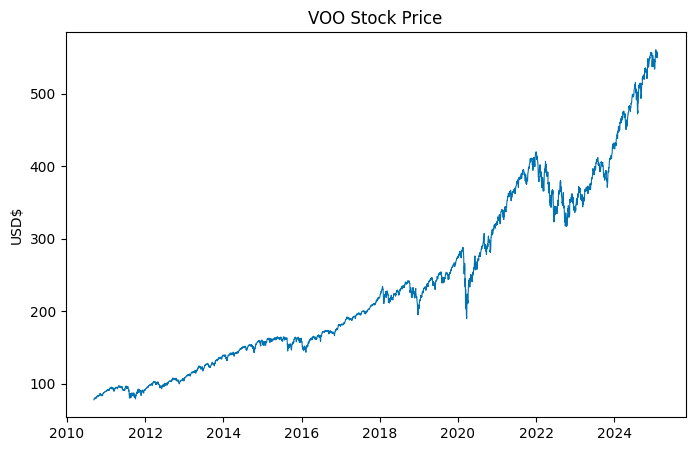

In [140]:
ticks = voo[['Close']]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ticks, lw=.8)
ax.set(title="VOO Stock Price", ylabel="USD$")
plt.show()

# Data Preprocessing

## Train Test Split

In [141]:
train = ticks[:int(ticks.shape[0] * .5)]
validate = ticks[int(ticks.shape[0] * .5): int(ticks.shape[0] * .75)]
test = ticks[int(ticks.shape[0] * .75):]
print(f'train: {train.shape}\nvalidate: {validate.shape}\ntest: {test.shape}')

train: (1813, 1)
validate: (907, 1)
test: (907, 1)


## Normalisation

In [142]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns=['index'], index=train.index)
validate_scaled = pd.DataFrame(scaler.transform(validate), columns=['index'], index=validate.index)
test_scaled = pd.DataFrame(scaler.transform(test), columns=['index'], index=test.index)

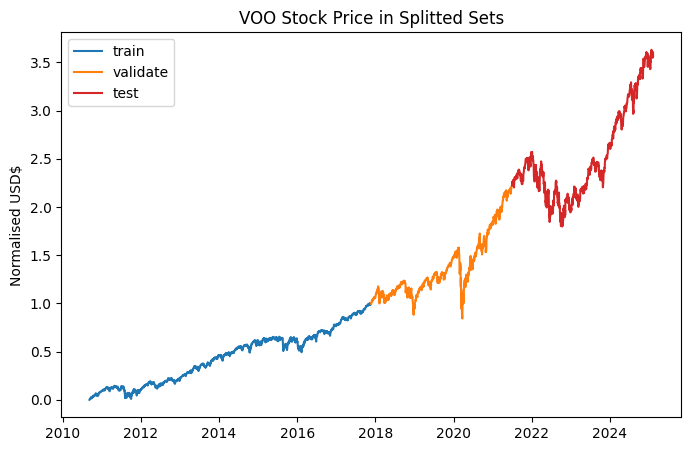

In [143]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_scaled, color='tab:blue', label='train')
ax.plot(validate_scaled, color='tab:orange', label='validate')
ax.plot(test_scaled, color='tab:red', label='test')
ax.legend()
plt.title("VOO Stock Price in Splitted Sets")
plt.xlabel("")
plt.ylabel("Normalised USD$")
plt.show()

## Windowed Datasets

In [144]:
window_size = 1
X_train, y_train = create_dataset(train_scaled, window_size=window_size)
X_val, y_val = create_dataset(validate_scaled, window_size=window_size)
X_test, y_test = create_dataset(test_scaled, window_size=window_size)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\ny_val: {y_val.shape}")
print(f"X_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1812, 1)
y_train: (1812,)
X_val: (906, 1)
y_val: (906,)
X_test: (906, 1)
y_test: (906,)


## Reshape for modelling

In [145]:
def reshape_df(df):
    return np.reshape(df, (df.shape[0], 1, df.shape[1]))

X_train_reshaped = reshape_df(X_train)
X_val_reshaped = reshape_df(X_val)
X_test_reshaped = reshape_df(X_test)

# Modelling

In [146]:
def model_eval(model, epochs=5):
    # Fit model
    model.fit(X_train_reshaped, y_train, epochs=5)

    # Make predictions on train and validate data
    train_pred = model.predict(X_train_reshaped)
    val_pred = model.predict(X_val_reshaped)
    test_pred = model.predict(X_test_reshaped)

    # Un-scale the predictions
    train_pred_rescaled = scaler.inverse_transform(train_pred)
    val_pred_rescaled = scaler.inverse_transform(val_pred)
    test_pred_rescaled = scaler.inverse_transform(test_pred)

    # Load in the original data (for comparison)
    baseline = ticks
    ########
    def rewindow_train_indexes(window, train_pred):
        return window, len(train_pred) + window

    def rewindow_val_indexes(window, train_pred, val_pred):
        return len(train_pred) + 2*window, len(train_pred) + 2*window + len(val_pred)

    def rewindow_test_indexes(window, train_pred, val_pred):
        return len(train_pred) + len(val_pred) + 3*window, None

    train_start, train_end = rewindow_train_indexes(window_size, train_pred_rescaled)
    val_start, val_end = rewindow_val_indexes(window_size, train_pred_rescaled, val_pred_rescaled)
    test_start, test_end = rewindow_test_indexes(window_size, train_pred_rescaled, val_pred_rescaled)
    ########
    # Un-window the training predictions
    plot_train_pred = np.empty((len(baseline)))
    plot_train_pred[:] = np.nan
    plot_train_pred[train_start:train_end] = train_pred_rescaled[:,0]
    # Un-window the validate predictions
    plot_val_pred = np.empty((len(baseline)))
    plot_val_pred[:] = np.nan
    plot_val_pred[val_start:val_end] = val_pred_rescaled[:,0]
    # Un-window the test predictions
    plot_test_pred = np.empty((len(baseline)))
    plot_test_pred[:] = np.nan
    plot_test_pred[test_start:test_end] = test_pred_rescaled[:,0]
    # Plot the original data
    plt.plot(baseline, label="Original Data")
    # Plot the predictions
    plt.plot(baseline.index, plot_train_pred, label="Training Set Predictions")
    plt.plot(baseline.index, plot_val_pred, label="Validation Set Predictions")
    plt.plot(baseline.index, plot_test_pred, label="Test Set Predictions")

    # Add title, axis labels, and a legend
    plt.title('VOO Stock Price Predictions by Training, Validation, and Test Sets')
    plt.xlabel('Date')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()
    plt.xticks(rotation=45)
    plt.ylabel('Index')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    print(f"R2 score for training: {r2_score(scaler.inverse_transform([y_train])[0], train_pred_rescaled)}")
    print(f"R2 score for validation: {r2_score(scaler.inverse_transform([y_val])[0], val_pred_rescaled)}")
    print(f"R2 score for test: {r2_score(scaler.inverse_transform([y_test])[0], test_pred_rescaled)}")

## Baseline Model - SimpleRNN

/Users/moswai/Documents/Mos_DataScience/tools/venv/venv_DL_tickers/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.1435 
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 0.0193
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.0105
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.0066
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.0036
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


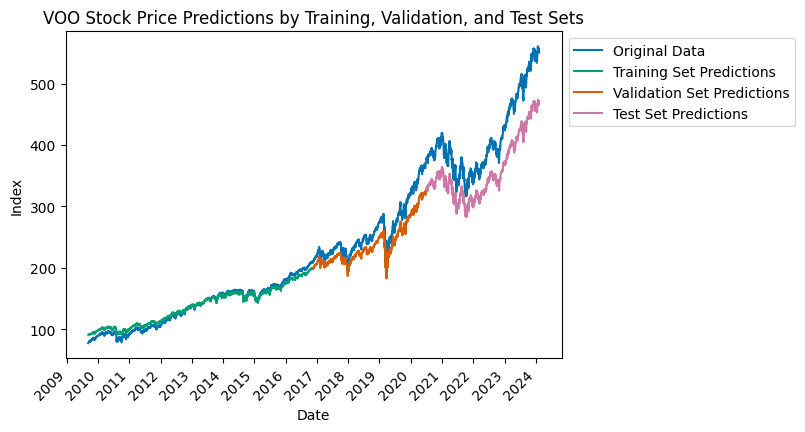

R2 score for training: 0.9718339864158351
R2 score for validation: 0.6997528465541489
R2 score for test: 0.19812384387182336


In [147]:
# Modelling
model = tf.keras.Sequential()

model.add(layers.SimpleRNN(10, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model_eval(model, 5)

* The model only performs well for `training` set.
* After 2017, the trend of the index began to increase more steeply and erratically, the performance of the model fell as shown in `validation` and `test` sets' predictions.

## Model Tuning

X_train: (1788, 25)
y_train: (1788,)
X_val: (882, 25)
y_val: (882,)
X_test: (882, 25)
y_test: (882,)


/Users/moswai/Documents/Mos_DataScience/tools/venv/venv_DL_tickers/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_43 (Conv1D)              │ (None, 1, 128)         │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - loss: 0.0342 
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 0.0015
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.0014
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.0013
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0012
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


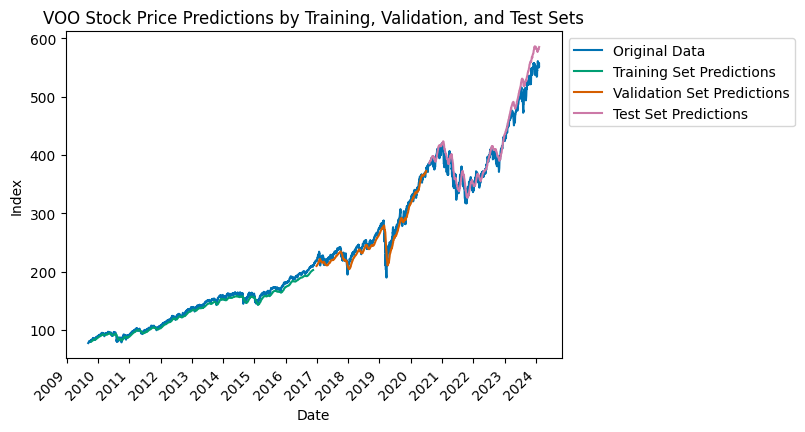

R2 score for training: 0.9783157457193782
R2 score for validation: 0.9451759345470667
R2 score for test: 0.9392931298269583


In [ ]:
# Re-window datasets
window_size = 25
X_train, y_train = create_dataset(train_scaled, window_size=window_size)
X_val, y_val = create_dataset(validate_scaled, window_size=window_size)
X_test, y_test = create_dataset(test_scaled, window_size=window_size)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\ny_val: {y_val.shape}")
print(f"X_test: {X_test.shape}\ny_test: {y_test.shape}")
# Reshaping
X_train_reshaped = reshape_df(X_train)
X_val_reshaped = reshape_df(X_val)
X_test_reshaped = reshape_df(X_test)

# Modelling
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, 1, activation='relu', input_shape=(1, window_size)))
model.add(layers.MaxPooling1D(1))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()

model_eval(model, 40)

* A tuned `Convolutional-RNN` model with a `GRU` layer significantly improves both the `validation` and `test` sets predictions with a slight decrease in the $R^2$ by around $.05$.